In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(device)

from utils import *

cuda:0


In [73]:
## preprocess this subset of data
p_data, n_data = "data/orig_species.pkl", ""
data_df = pickle.load(open(p_data, "rb"))
idx, data_df = data_df.iloc[:, :1], data_df.iloc[:, 1:]

## remove the vague species (order unknown for na_thres=3)
na_thres = 3
col_drops = [col for col in list(data_df.columns) if(col.split(".").count("NA")>=na_thres)]
data_df = data_df.drop(col_drops, axis=1)

# remove emtpy samples first
idx = idx.loc[data_df.sum(axis=1) > 0]
data_df = data_df.loc[data_df.sum(axis=1) > 0]
'''
remove the samples w/ low total abundance. 
I checked that total abundance ~lognormal; remove the <-2sigma (~5%) lowest samples. 
'''
lower_bound = np.exp(np.mean(np.log(data_df.sum(axis=1)))-2*np.std(np.log(data_df.sum(axis=1))))
idx = idx.loc[data_df.sum(axis=1) >= lower_bound]
data_df = data_df.loc[data_df.sum(axis=1) >= lower_bound]

## remove the rare species (present in <1% samples)
n_samples = data_df.shape[0]
data_df = data_df.loc[:, (data_df>0).sum(axis=0) >= 0.01*n_samples]

idx = idx.loc[data_df.sum(axis=1) > 0]
data_df = data_df.loc[data_df.sum(axis=1) > 0]

## separate train and test
# features = np.floor(data_df.values/20)
features = data_df.values
labels = data_df.values
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

## without any additional transformations
X_train_scaled=torch.from_numpy(X_train).float()
X_test_scaled=torch.from_numpy(X_test).float()

## make dataset
class CustomDataset(Dataset):
    def __init__(self, x, device=None):
        self.x = x
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx]
    
Train = CustomDataset(X_train_scaled)
Test = CustomDataset(X_test_scaled)

## create batch spits of data
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=True, **kwargs)
test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=True, **kwargs)

In [74]:
for data in train_DS:
    if(torch.isnan(data).any()):
        print(data)
        
for data in test_DS:
    if(torch.isnan(data).any()):
        print(data)

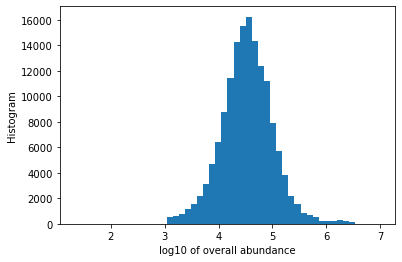

10.434042267085065 1.1017261618076946


In [75]:
# the sum of absolute abundances (should be reflected by learnable factor l) is lognormal
plt.hist(np.log10(np.sum(features, axis=1)), bins=50)
plt.xlabel("log10 of overall abundance")
plt.ylabel("Histogram")
plt.show()
all_libsize = np.log(np.sum(features, axis=1))
mu0_prior, sigma0_prior = np.mean(all_libsize), np.std(all_libsize)
print(mu0_prior, sigma0_prior)

In [76]:
class scviVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=128, hidden_dim=1024, dropout_rate=0.1):
        super().__init__()
        # Shared encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        # z encoder
        self.fc_mu_z = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar_z = nn.Linear(hidden_dim, latent_dim)
        # library-size encoder (log l)
        self.fc_mu_l = nn.Linear(hidden_dim, 1)
        self.fc_logvar_l = nn.Linear(hidden_dim, 1)
        # rho decoder (mean)
        self.decoder_rho = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Softplus()
        )
        # dropout decoder (pi)
        self.decoder_pi = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        # Species-specific scale factor and dispersion
        self.log_s = nn.Parameter(torch.zeros(input_dim))
        self.log_theta = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        h = self.encoder(x)
        if(torch.isnan(h).any()):
            print("bad encoder!", h)
        mu_z = self.fc_mu_z(h)
        logvar_z = self.fc_logvar_z(h)
        mu_l = self.fc_mu_l(h)
        logvar_l = self.fc_logvar_l(h)
        return mu_z, logvar_z, mu_l, logvar_l

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, l_latent):
        rho = self.decoder_rho(z)         # positive
        pi = self.decoder_pi(z)           # [0,1]
        if(torch.isnan(pi).any()):
            print(z)
        s = torch.exp(self.log_s)         # positive
        theta = torch.exp(self.log_theta) # positive
        l = torch.exp(l_latent) * s       # broadcast to (batch, features)
        mu = rho * l
        return mu, theta, pi

    def forward(self, x):
        # x: raw counts (batch_size, input_dim)
        mu_z, logvar_z, mu_l, logvar_l = self.encode(x)
        z = self.reparameterize(mu_z, logvar_z)
        l_latent = self.reparameterize(mu_l, logvar_l)
        mu, theta, pi = self.decode(z, l_latent)
        return mu, theta, pi, mu_z, logvar_z, mu_l, logvar_l

In [77]:
# zinb loss
def zinb_loss(x, mu, theta, pi, eps=1e-6):
    t1 = torch.lgamma(x + theta) - torch.lgamma(theta) - torch.lgamma(x + 1)
    t2 = theta * (torch.log(theta + eps) - torch.log(mu + theta + eps)) \
         + x * (torch.log(mu + eps) - torch.log(mu + theta + eps))
    log_nb = t1 + t2
    log_pi = torch.log(pi + eps)
    log_1_pi = torch.log1p(-pi + eps)
    log_prob_zero = torch.logaddexp(log_pi, log_1_pi + log_nb)
    log_prob_nonzero = log_1_pi + log_nb
    mask_zero = (x < 0.5).float()
    loglik = mask_zero * log_prob_zero + (1 - mask_zero) * log_prob_nonzero
    return -torch.sum(loglik)

# full elbo
def compute_elbo(model, x, kl_weight=1.0, mu_l_prior=0.0, sigma_l_prior=1.0):
    # when using the model, do a log transform on x
    mu, theta, pi, mu_z, logvar_z, mu_l, logvar_l = model(torch.log10(1+x))
    # Reconstruction loss
    rec_loss = zinb_loss(x, mu, theta, pi)
    # KL for z ~ N(0,1)
    kl_z = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
    # KL for l ~ N(mu_l_prior, sigma_l_prior^2)
    var_l = torch.exp(logvar_l)
    kl_l = 0.5 * torch.sum(
        (var_l + (mu_l - mu_l_prior).pow(2)) / (sigma_l_prior**2)
        - 1 - logvar_l + 2 * torch.log(sigma_l_prior)
    )
    elbo = rec_loss + kl_weight * (kl_z + kl_l)
    return elbo, rec_loss, kl_z, kl_l

In [78]:
def get_metrics(x, mu, theta, pi):
    # sample ZINB
    bern = torch.bernoulli(pi)
    probs = theta / (theta + mu)        
    nb_dist = torch.distributions.NegativeBinomial(total_count=theta, probs=probs)
    nb_sample = nb_dist.sample()
    zinb_sample = torch.where(bern.bool(), torch.zeros_like(nb_sample), nb_sample)
    pred_binary = (zinb_sample > 0).float()
    true_binary = (x > 0).float()
    acc = (pred_binary == true_binary).float().mean().item()
    # correlation
    x_cent = x - x.mean(dim=1, keepdim=True)
    mu_cent = mu - mu.mean(dim=1, keepdim=True)
    cov = (x_cent * mu_cent).sum(dim=1)
    std_x = torch.sqrt((x_cent**2).sum(dim=1) + 1e-8)
    std_mu = torch.sqrt((mu_cent**2).sum(dim=1) + 1e-8)
    corr = (cov / (std_x * std_mu)).mean().item()
    return acc, corr

class Trainer:
    def __init__(self, model, train_loader, test_loader, optimizer, scheduler,
                 device='cuda:0', kl_weight=1.0, mu_l_prior=0.0, sigma_l_prior=1.0):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.kl_weight = kl_weight
        self.mu_l_prior = torch.tensor(mu_l_prior).to(device)
        self.sigma_l_prior = torch.tensor(sigma_l_prior).to(device)

    def train_epoch(self):
        self.model.train()
        metrics = { 'elbo':0, 'rec':0, 'kl_z':0, 'kl_l':0, 'acc':0, 'corr':0 }
        n_samples = 0
        for x in self.train_loader:
            x = x.to(self.device).float()
            
            self.optimizer.zero_grad()
            elbo, rec, kl_z, kl_l = compute_elbo(
                self.model, x,
                self.kl_weight,
                self.mu_l_prior,
                self.sigma_l_prior
            )
            for name, param in model.named_parameters():
                if torch.isnan(param).any() or torch.isinf(param).any():
                    print(f"NaN in weights: {name}")
            elbo.backward()
            self.optimizer.step()
            self.scheduler.step()
            bsz = x.size(0)
            
            # Metrics: accuracy and Pearson correlation
            with torch.no_grad():
                mu, theta, pi, *_ = self.model(x)
                acc, corr = get_metrics(x, mu, theta, pi)
            # Accumulate
            metrics['elbo'] += elbo.item()
            metrics['rec']  += rec.item()
            metrics['kl_z'] += kl_z.item()
            metrics['kl_l'] += kl_l.item()
            metrics['acc']  += acc * bsz
            metrics['corr'] += corr * bsz
            n_samples += bsz
        return {k: v / n_samples for k, v in metrics.items()}

    @torch.no_grad()
    def test_epoch(self):
        self.model.eval()
        metrics = { 'elbo':0, 'rec':0, 'kl_z':0, 'kl_l':0, 'acc':0, 'corr':0 }
        n_samples = 0
        for x in self.test_loader:
            x = x.to(self.device).float()
            
            elbo, rec, kl_z, kl_l = compute_elbo(
                self.model, x,
                self.kl_weight,
                self.mu_l_prior,
                self.sigma_l_prior
            )
            
            # Metrics
            mu, theta, pi, *_ = self.model(x)
            acc, corr = get_metrics(x, mu, theta, pi)
            # Accumulate
            bsz = x.size(0)
            metrics['elbo'] += elbo.item()
            metrics['rec']  += rec.item()
            metrics['kl_z'] += kl_z.item()
            metrics['kl_l'] += kl_l.item()
            metrics['acc']  += acc * bsz
            metrics['corr'] += corr * bsz
            n_samples += bsz
        return {k: v / n_samples for k, v in metrics.items()}

In [79]:
input_dim = X_test.shape[1]
latent_dim = 128
hidden_dim = 1024
dropout = 0.1
lr = 1e-4
weight_decay = 1e-4
epochs = 100
steps_per_epoch = len(train_DS)
total_steps = epochs*steps_per_epoch
kl_weight = 1.0
mu_l_prior = mu0_prior     
sigma_l_prior = sigma0_prior

# device = "cpu"

model = scviVAE(input_dim, latent_dim, hidden_dim, dropout)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=total_steps, # number of steps to divide the annealing process
                                                       eta_min=1e-6)
trainer = Trainer(
    model, train_DS, test_DS, optimizer, scheduler, 
    device, kl_weight, mu_l_prior, sigma_l_prior
)

train_ms, test_ms = [], []
for epoch in tqdm(range(1, epochs+1)):
    train_m = trainer.train_epoch()
    test_m  = trainer.test_epoch()
    if(epoch%10==0):
        print(f"Epoch {epoch:03d} | "
          f"Train ELBO: {train_m['elbo']:.3f}, Test ELBO: {test_m['elbo']:.3f} | "
          f"Rec: {train_m['rec']:.3f}/{test_m['rec']:.3f} | "
          f"KL_z: {train_m['kl_z']:.3f}/{test_m['kl_z']:.3f} | "
          f"KL_l: {train_m['kl_l']:.3f}/{test_m['kl_l']:.3f}")
    train_ms.append(train_m)
    test_ms.append(test_m)

# torch.save(model.state_dict(), 'full_scvi_like.pth')

 10%|█         | 10/100 [04:51<43:43, 29.15s/it]

Epoch 010 | Train ELBO: 443.947, Test ELBO: 499.290 | Rec: 426.564/482.583 | KL_z: 15.538/14.932 | KL_l: 1.845/1.775


 20%|██        | 20/100 [09:43<39:01, 29.27s/it]

Epoch 020 | Train ELBO: 432.689, Test ELBO: 466.531 | Rec: 415.280/449.384 | KL_z: 15.742/15.456 | KL_l: 1.668/1.691


 30%|███       | 30/100 [14:36<34:17, 29.39s/it]

Epoch 030 | Train ELBO: 429.761, Test ELBO: 458.456 | Rec: 411.760/440.624 | KL_z: 16.321/16.181 | KL_l: 1.680/1.651


 40%|████      | 40/100 [19:30<29:29, 29.49s/it]

Epoch 040 | Train ELBO: 428.236, Test ELBO: 457.964 | Rec: 409.818/439.717 | KL_z: 16.735/16.565 | KL_l: 1.683/1.681


 50%|█████     | 50/100 [24:24<24:24, 29.28s/it]

Epoch 050 | Train ELBO: 427.127, Test ELBO: 455.731 | Rec: 408.450/437.399 | KL_z: 16.996/16.666 | KL_l: 1.681/1.666


 60%|██████    | 60/100 [29:18<19:37, 29.44s/it]

Epoch 060 | Train ELBO: 426.455, Test ELBO: 456.879 | Rec: 407.627/438.274 | KL_z: 17.149/16.973 | KL_l: 1.679/1.631


 61%|██████    | 61/100 [29:58<19:09, 29.48s/it]


KeyboardInterrupt: 

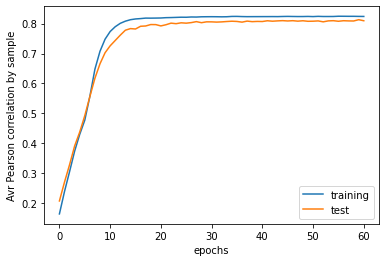

In [86]:
train_corrs = [i["corr"] for i in train_ms]
train_accs = [i["acc"] for i in train_ms]

test_corrs = [i["corr"] for i in test_ms]
test_accs = [i["acc"] for i in test_ms]

plt.plot(train_corrs, label="training")
plt.plot(test_corrs, label="test")
plt.xlabel("epochs")
plt.ylabel("Avr Pearson correlation by sample")
plt.legend()
plt.show()

In [107]:
state_dict = torch.load('full_scvi_like.pth')
model1 = scviVAE(input_dim, latent_dim, hidden_dim, dropout)
model1.load_state_dict(state_dict)

<All keys matched successfully>

In [159]:
# show the dist of data/prediction
model1.eval()
model1.to(device)
all_xs = []
all_mus = []
for x in tqdm(test_DS):
    x = x.to(device).float()
    mu, theta, pi, mu_z, logvar_z, mu_l, logvar_l = model1(torch.log10(1+x))
    bern = torch.bernoulli(pi)
    probs = theta / (theta + mu)        
    nb_dist = torch.distributions.NegativeBinomial(total_count=theta, probs=probs)
    nb_sample = nb_dist.sample()
    zinb_sample = torch.where(bern.bool(), torch.zeros_like(nb_sample), nb_sample)
    all_xs.append(x.detach().cpu().numpy())
    all_mus.append(mu.detach().cpu().numpy())
# plt.hist(X_test_scaled.flatten().numpy(), bins=50, alpha=0.4)
# plt.yscale("log")

100%|██████████| 149/149 [00:00<00:00, 177.65it/s]


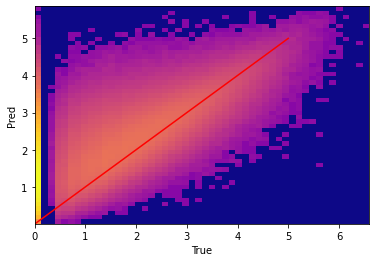

In [160]:
x = np.vstack(all_xs)
mu = np.vstack(all_mus)
true_x_list = np.log10(1+x)
recon_x_list = np.log10(1+mu)
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(0.1), cmap='plasma', bins=50)
plt.plot([0, 5], [0, 5], color="r")
plt.xlabel("True")
plt.ylabel("Pred")
plt.show()

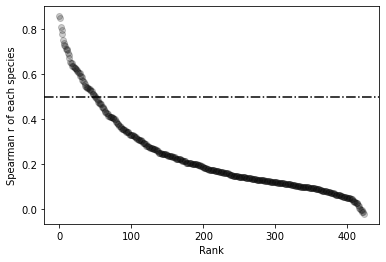

In [161]:
# spearman r by species
coeffs = []
for i in range(true_x_list.shape[1]):
    if not np.isnan(stats.spearmanr(true_x_list[:, i], recon_x_list[:, i])[0]):
        coeffs.append(stats.spearmanr(true_x_list[:, i], recon_x_list[:, i]))
coeffs_sorted = sorted(enumerate(coeffs), key=lambda x: x[1], reverse=True)
plt.scatter(range(len(coeffs)), [val[0] for (idx, val) in coeffs_sorted], color="k", alpha=0.2)
plt.axhline(0.5, color="k", linestyle="-.")
plt.xlabel("Rank")
plt.ylabel("Spearman r of each species")
plt.show()